# QAOA: Quantum Approximate Optimization Algorithm for Portfolio Selection

This notebook implements the **Quantum Approximate Optimization Algorithm (QAOA)** with a specialized **XY mixer** to solve the portfolio optimization problem with cardinality constraint.

## What is QAOA?

QAOA is a **hybrid quantum-classical variational algorithm** designed to solve combinatorial optimization problems.

**Key Features**:
- 🔵 **Quantum circuit**: Prepares parameterized quantum states
- 🟣 **Classical optimizer**: COBYLA (derivative-free, robust to noise)
- ✅ **XY mixer**: Preserves cardinality constraint throughout optimization

---



In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Quantum computing
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit_aer import AerSimulator

# Classical optimization
from scipy.optimize import minimize

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


## 1. Configuration

**Circuit Depth**: p = 6 (balance between quality and computational cost)
**Optimizer**: COBYLA (Constrained Optimization BY Linear Approximation)
**Multi-starts**: 30 random initializations to escape local minima


In [2]:
# === QAOA CONFIGURATION ===
CONFIG = {
    'p_layers': 6,          # Circuit depth
    'shots': 8000,          # Measurement samples
    'seed': 7,              # Random seed
    'multi_starts': 3,     # Number of random initializations
    'optimizer': 'COBYLA',  # Classical optimizer
    'max_iter': 250,        # Max iterations per run
    'rhobeg': 0.5,          # Initial step size
    'gpu_enabled': True     # GPU acceleration
}

P_LAYERS = CONFIG['p_layers']
SHOTS = CONFIG['shots']
SEED = CONFIG['seed']

rng = np.random.default_rng(SEED)

print("="*60)
print("           QAOA CONFIGURATION")
print("="*60)
for key, val in CONFIG.items():
    print(f"  {key:20s}: {val}")
print("="*60)


           QAOA CONFIGURATION
  p_layers            : 6
  shots               : 8000
  seed                : 7
  multi_starts        : 3
  optimizer           : COBYLA
  max_iter            : 250
  rhobeg              : 0.5
  gpu_enabled         : True


## 2. Load QUBO Problem Data


In [7]:
# ============================================================================
# FETCH AND PREPARE DATA (from Data and QUBO.ipynb)
# ============================================================================

data = np.load("data\portfolio_qubo_data.npz", allow_pickle=True)

Q = data['Q']
q = data['q']
mu = data['mu']
Sigma = data['Sigma']
B = int(data['B'])
TICKERS = list(data['TICKERS'])
n = len(TICKERS)

print("✓ Data loaded successfully.")
print(f"  n = {n} assets")
print(f"  B = {B} cardinality")
print(f"  Q shape: {Q.shape}")
print(f"  q shape: {q.shape}")

✓ Data loaded successfully.
  n = 21 assets
  B = 4 cardinality
  Q shape: (21, 21)
  q shape: (21,)


## 3. QUBO to Ising Transformation


In [4]:
def qubo_to_ising(Q, q):
    """Convert QUBO to Ising Hamiltonian"""
    n = len(q)
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)

print("\n✓ QUBO → Ising transformation complete")
print(f"  J shape: {J.shape}")
print(f"  h shape: {h.shape}")
print(f"  Constant: {const_shift:.6f}")



✓ QUBO → Ising transformation complete
  J shape: (21, 21)
  h shape: (21,)
  Constant: 1.281543


## 4. Initial State Preparation


In [5]:
# Random feasible initial state
init_idx = rng.choice(n, size=B, replace=False)
init_bits = np.zeros(n, dtype=int)
init_bits[init_idx] = 1

print("\n🎲 Initial State:")
print(f"  Selected assets: {[TICKERS[i] for i in init_idx]}")
print(f"  Cardinality: {init_bits.sum()} = {B} ✓")

init_cost = float(init_bits @ Q @ init_bits + q @ init_bits)
print(f"  Initial cost: {init_cost:.6f}")



🎲 Initial State:
  Selected assets: ['KO', 'XOM', 'CAT', 'UNH']
  Cardinality: 4 = 4 ✓
  Initial cost: 0.218993


## 5. Build QAOA Circuit with XY Mixer


In [6]:
def build_qaoa_xy(n, P, J, h, init_bits):
    """Construct QAOA ansatz with XY mixer"""
    qc = QuantumCircuit(n, name="QAOA_XY")
    
    # Initialize
    for i, bit in enumerate(init_bits):
        if bit == 1:
            qc.x(i)
    
    # Parameters
    gammas = [Parameter(f"γ_{k}") for k in range(P)]
    betas = [Parameter(f"β_{k}") for k in range(P)]
    
    # Ring topology
    ring_pairs = [(i, (i+1) % n) for i in range(n)]
    
    # Build layers
    for layer in range(P):
        γ = gammas[layer]
        β = betas[layer]
        
        # Cost layer
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        
        # Mixer layer
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    
    return qc, gammas + betas

print("\n🔧 Building QAOA circuit...")
ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

print(f"✓ Circuit constructed")
print(f"  Qubits: {ansatz.num_qubits}")
print(f"  Parameters: {len(theta_params)}")
print(f"  Depth: {ansatz.depth()}")
print(f"  Gates: {sum(ansatz.count_ops().values())}")



🔧 Building QAOA circuit...
✓ Circuit constructed
  Qubits: 21
  Parameters: 12
  Depth: 384
  Gates: 1642


## 6. Helper Functions


In [7]:
def f_qubo(x):
    """Calculate QUBO cost"""
    return float(x @ Q @ x + q @ x)

def bitarray_from_qiskit_string(s):
    """Convert Qiskit string to binary array"""
    return np.array([int(c) for c in s[::-1]], dtype=int)

def bind_params(circ, mapping):
    """Bind parameters to circuit"""
    return circ.assign_parameters(mapping, inplace=False)

def random_theta():
    """Generate random parameters"""
    return rng.uniform(0.0, 2.0*np.pi, size=2*P_LAYERS)

def is_valid_solution(x, B):
    """Check cardinality constraint"""
    return np.sum(x) == B

print("✓ Helper functions defined")


✓ Helper functions defined


## 7. Setup Quantum Backend


In [8]:
print("\n🖥️  Setting up quantum backend...")

try:
    if CONFIG['gpu_enabled']:
        try:
            gpu_backend = AerSimulator(device='GPU', method='statevector')
            test_qc = QuantumCircuit(2)
            test_qc.h(0)
            test_qc.measure_all()
            gpu_backend.run(test_qc, shots=10).result()
            print(f"✓ GPU backend initialized")
        except:
            gpu_backend = AerSimulator(method='statevector')
            print(f"✓ CPU backend initialized (GPU not available)")
    else:
        gpu_backend = AerSimulator(method='statevector')
        print(f"✓ CPU backend initialized")
except:
    gpu_backend = AerSimulator(method='statevector')
    print(f"✓ CPU backend initialized")

ansatz_meas = ansatz.copy()
ansatz_meas.measure_all()

print(f"\n🔧 Transpiling circuit...")
t_start = time.perf_counter()
t_ansatz = transpile(ansatz_meas, gpu_backend, optimization_level=1, seed_transpiler=SEED)
t_end = time.perf_counter()

print(f"✓ Transpiled in {t_end-t_start:.2f}s")
print(f"  Depth: {t_ansatz.depth()}")



🖥️  Setting up quantum backend...
✓ CPU backend initialized (GPU not available)

🔧 Transpiling circuit...
✓ Transpiled in 1.00s
  Depth: 385


## 8. Objective Function


In [9]:
qaoa_trace = []
iteration_count = [0]

def objective_from_shots(theta):
    """Evaluate QAOA objective via sampling"""
    param_dict = {p: float(t) for p, t in zip(theta_params, theta)}
    bound_circ = bind_params(t_ansatz, param_dict)
    
    result = gpu_backend.run(bound_circ, shots=SHOTS, seed_simulator=SEED).result()
    counts = result.get_counts()
    
    total_cost = 0.0
    valid_shots = 0
    
    for bitstring, count in counts.items():
        x = bitarray_from_qiskit_string(bitstring)
        if is_valid_solution(x, B):
            cost = f_qubo(x)
            total_cost += count * cost
            valid_shots += count
    
    if valid_shots == 0:
        return qaoa_trace[-1] if qaoa_trace else 0.0
    
    avg_cost = total_cost / valid_shots
    qaoa_trace.append(avg_cost)
    iteration_count[0] += 1
    
    if iteration_count[0] % 50 == 0:
        print(f"    Iter {iteration_count[0]:4d}: cost = {avg_cost:.6f}, valid = {valid_shots}/{SHOTS}")
    
    return avg_cost

print("✓ Objective function defined")


✓ Objective function defined


## 9. Multi-Start Optimization with COBYLA


In [10]:
print("\n" + "="*60)
print("        QAOA OPTIMIZATION (MULTI-START)")
print("="*60)

print(f"\n🎯 Running {CONFIG['multi_starts']} independent optimizations...")
print(f"   Optimizer: COBYLA")
print(f"   Max iterations per run: {CONFIG['max_iter']}")
print(f"   Shots per evaluation: {SHOTS}")

all_results = []
best_val = np.inf
best_theta = None
t_opt_start = time.perf_counter()

for run in range(CONFIG['multi_starts']):
    print(f"\n[Run {run+1}/{CONFIG['multi_starts']}]")
    
    x0 = random_theta()
    iteration_count[0] = 0
    
    try:
        result = minimize(
            objective_from_shots,
            x0,
            method='COBYLA',
            options={
                'maxiter': CONFIG['max_iter'],
                'rhobeg': CONFIG['rhobeg']
            }
        )
        
        all_results.append((run, result.fun, result.x, result.nfev))
        
        if result.fun < best_val:
            best_val = result.fun
            best_theta = result.x
            print(f"  ✓ New best: {best_val:.6f} ({result.nfev} evals)")
        else:
            print(f"  Result: {result.fun:.6f} ({result.nfev} evals)")
            
    except Exception as e:
        print(f"  ✗ Failed: {e}")
        continue

t_opt_end = time.perf_counter()
t_optimization = t_opt_end - t_opt_start

if best_theta is None:
    raise RuntimeError("All optimizations failed!")

print(f"\n" + "="*60)
print(f"✓ Optimization complete in {t_optimization:.2f}s")
print(f"  Successful runs: {len(all_results)}/{CONFIG['multi_starts']}")
print(f"  Total evaluations: {sum(r[3] for r in all_results)}")
print(f"  Best cost: {best_val:.6f}")
print(f"  Found in run: {[r[0]+1 for r in all_results if r[1] == best_val][0]}")
print("="*60)



        QAOA OPTIMIZATION (MULTI-START)

🎯 Running 3 independent optimizations...
   Optimizer: COBYLA
   Max iterations per run: 250
   Shots per evaluation: 8000

[Run 1/3]
    Iter   50: cost = 0.283175, valid = 8000/8000
    Iter  100: cost = 0.259250, valid = 8000/8000
  ✓ New best: 0.258999 (147 evals)

[Run 2/3]
    Iter   50: cost = 0.302329, valid = 8000/8000
    Iter  100: cost = 0.286996, valid = 8000/8000
  Result: 0.286095 (143 evals)

[Run 3/3]
    Iter   50: cost = 0.283564, valid = 8000/8000
    Iter  100: cost = 0.268143, valid = 8000/8000
  Result: 0.268098 (144 evals)

✓ Optimization complete in 332.38s
  Successful runs: 3/3
  Total evaluations: 434
  Best cost: 0.258999
  Found in run: 1


## 10. Final Solution Extraction


In [11]:
print("\n📊 Final sampling with optimized parameters...")

final_circ = bind_params(t_ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})

t_sample_start = time.perf_counter()
final_result = gpu_backend.run(final_circ, shots=SHOTS, seed_simulator=SEED).result()
t_sample_end = time.perf_counter()

final_counts = final_result.get_counts()

print(f"✓ Sampling complete in {t_sample_end-t_sample_start:.2f}s")
print(f"  Unique bitstrings: {len(final_counts)}")

# Extract valid solutions
valid_solutions = []
for bitstring, count in final_counts.items():
    x = bitarray_from_qiskit_string(bitstring)
    if is_valid_solution(x, B):
        cost = f_qubo(x)
        valid_solutions.append((bitstring, count, cost, x))

valid_solutions.sort(key=lambda t: t[2])

print(f"  Valid solutions: {len(valid_solutions)}")
print(f"  Valid shot %: {sum(s[1] for s in valid_solutions)/SHOTS*100:.2f}%")

if not valid_solutions:
    raise RuntimeError("No valid solutions found!")

s_best, c_best, fx_best, x_best = valid_solutions[0]
sel_idx = np.where(x_best == 1)[0]
sel_tickers = [TICKERS[i] for i in sel_idx]



📊 Final sampling with optimized parameters...
✓ Sampling complete in 0.75s
  Unique bitstrings: 71
  Valid solutions: 71
  Valid shot %: 100.00%


## 11. Results and Financial Metrics


In [12]:
# Calculate financial metrics
w = np.zeros(n)
w[sel_idx] = 1.0 / B
mu_ann = 252 * float(mu @ w)
std_ann = np.sqrt(252 * float(w @ Sigma @ w))
sharpe_qaoa = mu_ann / std_ann if std_ann > 1e-6 else 0.0

print("\n" + "="*60)
print("              QAOA RESULTS")
print("="*60)

print(f"\n🎯 Optimal Parameters:")
print(f"  γ (cost): {best_theta[:P_LAYERS]}")
print(f"  β (mixer): {best_theta[P_LAYERS:]}")

print(f"\n📊 Best Solution:")
print(f"  Bitstring: {s_best}")
print(f"  Frequency: {c_best}/{SHOTS} ({c_best/SHOTS*100:.2f}%)")
print(f"  QUBO cost: {fx_best:.6f}")

print(f"\n💼 Selected Portfolio (B={B}):")
for i, ticker in enumerate(sel_tickers, 1):
    print(f"  {i}. {ticker:6s} - {100/B:.2f}%")

print(f"\n📈 Financial Metrics:")
print(f"  Annualized Return:     μ = {mu_ann:.6f} ({mu_ann*100:.2f}%)")
print(f"  Annualized Volatility: σ = {std_ann:.6f} ({std_ann*100:.2f}%)")
print(f"  Sharpe Ratio:         SR = {sharpe_qaoa:.3f}")

print(f"\n⏱️  Computation Time:")
print(f"  Optimization: {t_optimization:.2f}s")
print(f"  Final sampling: {t_sample_end-t_sample_start:.2f}s")
print(f"  Total: {t_optimization + (t_sample_end-t_sample_start):.2f}s")
print("="*60)



              QAOA RESULTS

🎯 Optimal Parameters:
  γ (cost): [1.94079519 6.00036151 0.5035359  5.08422308 4.9390249  2.68239879]
  β (mixer): [1.62217139 2.40844872 2.29739524 2.41356509 3.96013771 3.18735545]

📊 Best Solution:
  Bitstring: 001000110000010000000
  Frequency: 3/8000 (0.04%)
  QUBO cost: 0.173986

💼 Selected Portfolio (B=4):
  1. TSLA   - 25.00%
  2. UNH    - 25.00%
  3. PG     - 25.00%
  4. CAT    - 25.00%

📈 Financial Metrics:
  Annualized Return:     μ = 0.043230 (4.32%)
  Annualized Volatility: σ = 0.185168 (18.52%)
  Sharpe Ratio:         SR = 0.233

⏱️  Computation Time:
  Optimization: 332.38s
  Final sampling: 0.75s
  Total: 333.13s


## 12. Performance Analysis


In [ ]:
# Compare with brute-force
try:
    bf_data = np.load("data\bruteforce_results.npz", allow_pickle=True)
    fx_optimal = float(bf_data['fx_bruteforce'])
    
    gap_abs = fx_best - fx_optimal
    gap_rel = abs(gap_abs / fx_optimal) * 100
    
    print("\n🔍 Performance vs Global Optimum:")
    print(f"  QAOA solution:        {fx_best:.6f}")
    print(f"  Global optimum:       {fx_optimal:.6f}")
    print(f"  Absolute gap:         {gap_abs:.6f}")
    print(f"  Relative gap:         {gap_rel:.2f}%")
    
    if gap_rel < 1:
        print(f"  ✅ Excellent: <1% from optimum")
    elif gap_rel < 5:
        print(f"  ✓ Very good: <5% from optimum")
    elif gap_rel < 10:
        print(f"  ✓ Good: <10% from optimum")
    elif gap_rel < 20:
        print(f"  ⚠️ Acceptable: <20% from optimum")
    else:
        print(f"  ❌ Poor: >20% from optimum")
    
    print("\n💡 To improve further:")
    print("  • Increase p_layers to 8-10")
    print("  • Increase shots to 16,000")
    print("  • Increase multi_starts to 50-100")
    
except FileNotFoundError:
    print("\n⚠️ Brute-force results not available")
    print("   Run Brute-Force-Method.ipynb to enable comparison")



🔍 Performance vs Global Optimum:
  QAOA solution:        0.173986
  Global optimum:       0.147206
  Absolute gap:         0.026780
  Relative gap:         18.19%
  ⚠️ Acceptable: <20% from optimum

💡 To improve further:
  • Increase p_layers to 8-10
  • Increase shots to 16,000
  • Increase multi_starts to 50-100


## 13. Save Results


In [ ]:
# Save results
np.savez_compressed(
    "data\qaoa_results.npz",
    fx_qaoa=np.array(fx_best),
    x_qaoa=x_best,
    selected_assets=np.array(sel_tickers, dtype=object),
    mu_ann_qaoa=np.array(mu_ann),
    std_ann_qaoa=np.array(std_ann),
    sharpe_qaoa=np.array(sharpe_qaoa),
    best_theta=best_theta,
    optimization_time=np.array(t_optimization),
    qaoa_trace=np.array(qaoa_trace),
    all_costs=np.array([r[1] for r in all_results]),
    p_layers=np.array(P_LAYERS),
    shots=np.array(SHOTS),
    multi_starts=np.array(CONFIG['multi_starts'])
)

print("\n✓ Results saved to 'data\qaoa_results.npz'")
print(f"  Saved data:")
print(f"    - Solution and cost")
print(f"    - Financial metrics")
print(f"    - Optimization parameters")
print(f"    - Convergence trace")



✓ Results saved to 'qaoa_results.npz'
  Saved data:
    - Solution and cost
    - Financial metrics
    - Optimization parameters
    - Convergence trace


## 14. Visualizations


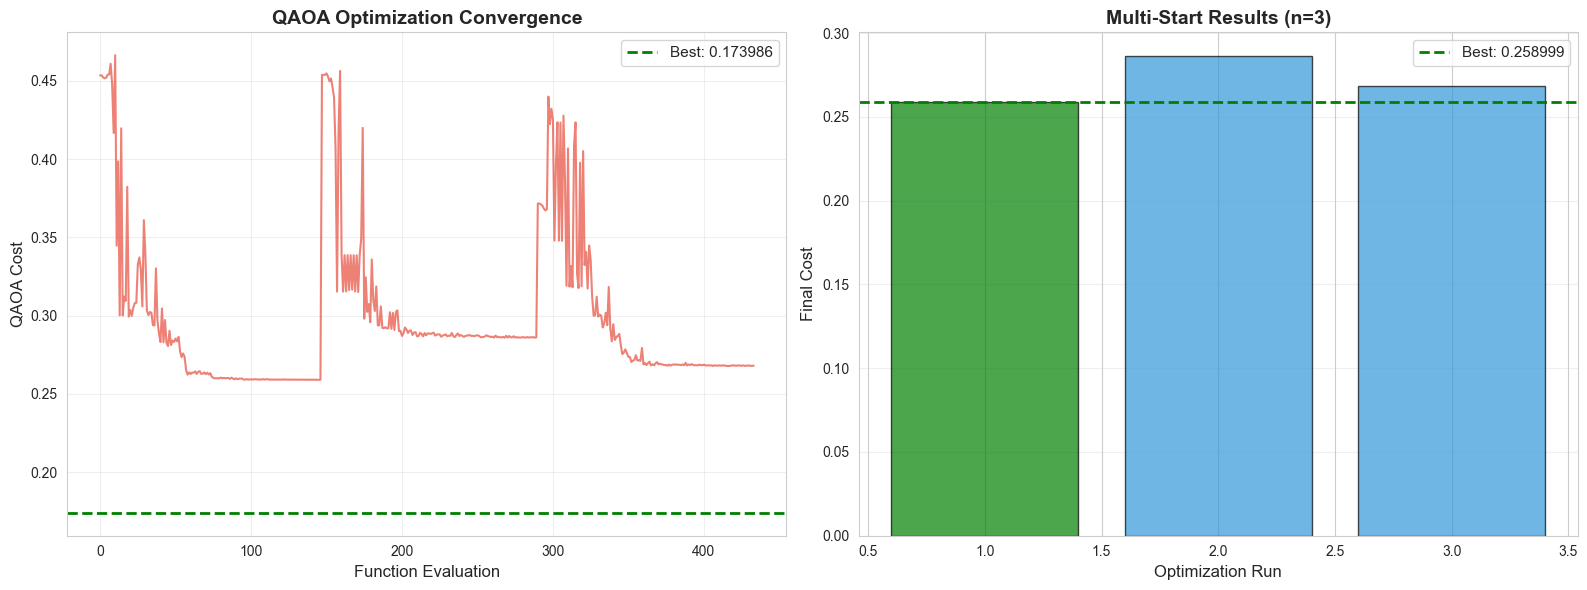


✓ Plots saved to 'qaoa_convergence.png'


In [ ]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Convergence
axes[0].plot(qaoa_trace, linewidth=1.5, alpha=0.7, color='#e74c3c')
axes[0].axhline(y=fx_best, color='green', linestyle='--', linewidth=2, label=f'Best: {fx_best:.6f}')
axes[0].set_xlabel('Function Evaluation', fontsize=12)
axes[0].set_ylabel('QAOA Cost', fontsize=12)
axes[0].set_title('QAOA Optimization Convergence', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Plot 2: Multi-start comparison
run_ids = [r[0]+1 for r in all_results]
run_costs = [r[1] for r in all_results]
colors = ['green' if c == best_val else '#3498db' for c in run_costs]

axes[1].bar(run_ids, run_costs, color=colors, edgecolor='black', alpha=0.7)
axes[1].axhline(y=best_val, color='green', linestyle='--', linewidth=2, label=f'Best: {best_val:.6f}')
axes[1].set_xlabel('Optimization Run', fontsize=12)
axes[1].set_ylabel('Final Cost', fontsize=12)
axes[1].set_title(f'Multi-Start Results (n={CONFIG["multi_starts"]})', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures\qaoa_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plots saved to 'qaoa_convergence.png'")
